In [1]:
import numpy as np
import pickle
import tensorly as tf
from skfda.representation.basis import BSplineBasis
from scipy.linalg import solve_sylvester
from scipy.sparse.linalg import LinearOperator, gmres
from scipy.special import softmax
from scipy.stats import matrix_normal as mvn
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.padder import PaddingTransformer
import pandas as pd
import warnings

# tf.set_backend('cupy')
rng = np.random.default_rng()

# %matplotlib notebook

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

cmap = plt.cm.viridis(np.linspace(0, 1, 3))

In [2]:
def nearPSD(X):
    
    assert len(X.shape) == 2
    X = (X + X.T) / 2
    D, Q = np.linalg.eigh(X)
    D = np.clip(D, 0, np.inf)
    return Q @ np.diag(D) @ Q.T

def matSqrt(X):
    
    assert len(X.shape) == 2
    X = (X + X.T) / 2
    D, Q = np.linalg.eigh(X)
#     print(D)
    D = np.sqrt(np.clip(D, 0, np.inf))
#     print(D)
    return Q @ np.diag(D) @ Q.T

# Data Loading and Preprocessing

The data is in the form of two lists: $X$ and $y$, each of size `n_samples`. $y$ is simply a list of targets, where each element is the class that the corresponding element in $X$ belongs to. $X$ is a list of $(T_i+1)\times(F_i+1)$ matrices, where the first column stores the timepoints and the first row stores the features recorded for each sample. The other elements are feature values at the corresponding timepoints.

## Data Loading and Plotting

The data is loaded from the `data.pickle` file, and one sample from each class is plotted. Each plot represents one feature, and each colour represents one class.

In [3]:
xs = np.linspace(0, 1, 12)
err = 10
nClasses = 3
nSubjects = [100 for i in range(nClasses)]
n_t = 12
nFeatures = 2
fnLibrary = np.array([err + np.log(xs + np.exp(-err)), err * np.exp(-25*(xs - .5)**2), err/(1 + np.exp(-10*(xs - 0.5))), 1/(xs + 1/err), err * (1 - np.exp(-25*(xs - .5)**2)), err/(1 + np.exp(10*(xs - 0.5)))])
indices = np.arange(6)
rng.shuffle(indices)
ys = fnLibrary[indices].T
Sigma = nearPSD(rng.random((n_t, n_t))) + 1e-7 * np.eye(n_t)
Psi = nearPSD(rng.random((nFeatures, nFeatures))) + 1e-7 * np.eye(nFeatures)
arNoise = mvn(rowcov=Sigma, colcov=Psi)
measurementNoise = mvn(rowcov=np.eye(n_t), colcov=np.eye(nFeatures))

In [4]:
X_test, y_test = [], []
for i in range(np.sum(nSubjects)):
    currY = i // 100
#     print(currY * nFeatures, (currY + 1) * nFeatures)
    currX = ys[:, currY * nFeatures: (currY + 1) * nFeatures] + arNoise.rvs() + measurementNoise.rvs()
    currX = (currX - currX.mean(0)) / (currX.max(0) - currX.min(0))
    currX -= currX.min(0)
    currX = np.hstack((np.atleast_2d(np.arange(n_t)).T, currX))
    currX = np.vstack((np.hstack((np.nan, np.arange(nFeatures))), currX))
    X_test.append(currX)
    y_test.append(currY)

# Model

The model is implemented as an instance of a scikit-learn `estimator` class. It implements interface functions `transform`, `fit_transform`, `predict`, `predict_proba` and `predict_log_proba` according to the specification, and can also be used in the beginning of a scikit-learn `Pipeline` in order to transform irregular tensor data into an `n_samples`$\times$`r` matrix, which can then be further processed using other scikit-learn estimators.

Assume that data is recorded at $T$ timepoints and for $F$ features. Let there be $K$ classes $i=1,2,\ldots,K$ and $j=1,2,\ldots,m_i$ subjects in each class. For each subject, let the timepoints recorded be $t_1, t_2,\ldots,t_{T_{ij}}$ and the features recorded be $f_1,f_2,\ldots,f_{F_{ij}}$. The model can be described as $$Y_{ij}=S_{ij}(\lambda_0 + \Lambda\alpha_i\xi + \gamma_{ij})C_{ij} + \epsilon_{ij}$$
Here $Y_{ij}\in\mathbb{R}^{T_{ij}\times F_{ij}}$ are the data matrices, where each row is a timepoint and each column is a feature. $S_{ij}$s are the spline matrices, formed from the spline basis function set $\{\mathbf{s}_1(t), \mathbf{s}_2(t),\ldots,\mathbf{s}_b(t)\}$. Similar to $Y_{ij}$, the rows are timepoints and the columns are basis functions, so the matrix is defined as $$S_{ij}=\begin{bmatrix}
\mathbf{s}_1(t_1) &\mathbf{s}_2(t_1) &\cdots &\mathbf{s}_b(t_1)\\
\mathbf{s}_1(t_2) &\mathbf{s}_2(t_2) &\cdots &\mathbf{s}_b(t_2)\\
&\vdots\\
\mathbf{s}_1(t_{T_{ij}}) &\mathbf{s}_2(t_{T_{ij}}) &\cdots &\mathbf{s}_b(t_{T_{ij}})\\
\end{bmatrix}$$ $C_{ij}\in\mathbb{R}^{F\times F_{ij}}$ are the $\{f_1^{th}, f_2^{th},\ldots,f_{F_{ij}}^{th}\}$ columns of an $F\times F$ identity matrix, $\lambda_0\in\mathbb{R}^{b\times F}$ is the mean parameter, $\alpha_i\in\mathbb{R}^{r\times r}$s are the reduced rank linear discriminants, $\Lambda\in\mathbb{R}^{b\times r}$ and $\xi\in\mathbb{R}^{r\times F}$ are matrices used to compute the full rank linear discriminants, $\gamma_{ij}\in\mathcal{N}_{b\times F}(0,\Sigma,\Psi)$ is the internal autoregressive noise and $\epsilon_{ij}\sim\mathcal{N}_{T_{ij}\times F_{ij}}(0,\sigma^2I)$ is the measurement noise.
We use an ECM algorithm to fit the model to the data, for computational efficiency.

In [16]:
class MFLDA(BaseEstimator, TransformerMixin, ClassifierMixin):
    
    def __init__(self, r=2, nBasis=4, SigmaRank = None, PsiRank = None, splineOrder = 3, regularizer=1e-7, n_iter=1000, criterion='bic'):
        
        # Initializing all hyperparameters
        
        self.nBasis = nBasis #Number of spline basis functions used
        self.r = r #Number of dimensions to reduce to
        self.SigmaRank = SigmaRank #Rank of Sigma, or time autocovariance(used to avoid local maximas)
        self.PsiRank = PsiRank #Rank of Psi, or feature autocovariance(used to avoid local maximas)
        self.splineOrder = splineOrder #Order of the spline, deafult is 3
        self.regularizer = regularizer #Regularization value used to compute inverses of non-invertible matrices
        self.n_iter = n_iter #Number of iterations to run for the ECM algorithm
        self.criterion = 'bic'
        super().__init__()
        
    def preprocess(self, X):

        t = []
        f = []
        x = []
        for i in range(len(X)):
            t.append(X[i][1:, 0])
            f.append(X[i][0, 1:])
            x.append(X[i][1:,1:])
#                 t.append(X[i][1:, 0].get())
#                 f.append(X[i][0, 1:].get())
#                 x.append(X[i][1:,1:].get())

        return t, f, x

    def Estep(self, x, y, S, C):

        #Takes one sample and performs the E-Step for that sample to compute the corresponding gamma'
        
        #Set up the Sylvester equation
        beta = self.lambda0_ + self.Lambda_ @ np.diag(self.alpha_[y]) @ self.xi_
        PsiPrime = C.T @ self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T @ C
        SigmaPrime = S @ self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T @ S.T
        centeredX = (x - S @ beta @ C) @ PsiPrime.T
        
        #Solve the Sylvester equation
        gamma = solve_sylvester(self.sigma2_ * np.linalg.pinv(SigmaPrime), PsiPrime.T, centeredX)
        gamma = np.array(gamma)

        return gamma
        
    
    # Compute the parameters lambda0, Lambda, alpha, xi
    def MStepLinear(self, x, y, m, gammaPrime, S, C):
        
        #Define LHS of first equation as a function instead of a matrix multiply. This allows us to use GMRES
        #and solve the matrix equation without a large matrix inversion
        def mv(v, target):
            
            v = v.reshape(self.n_features, self.nBasis).T
            s = np.zeros((self.nBasis, self.n_features))
            impIdxs = np.where(y == target)[0] #Choose samples belonging to the current class
            for i in impIdxs:
                s += S[i].T @ S[i] @ v @ C[i] @ C[i].T #Multiply and add the corresponding S and C matrices
            s = s.T.flatten()
            return s
        
        #Convert the above function into a linear operator and solve using GMRES
        A = [LinearOperator((self.nBasis * self.n_features, self.nBasis * self.n_features), matvec=lambda x: mv(x, i)) for i in range(self.n_classes)]
        b = np.zeros((self.n_classes, self.nBasis, self.n_features))
        for i in range(len(x)):
            centeredX = x[i] - gammaPrime[i]
            b[y[i]] += S[i].T @ centeredX @ C[i].T
        beta = [gmres(A[i], b[i].T.flatten())[0].reshape(self.n_features, self.nBasis).T for i in range(self.n_classes)]
        lambda0 = np.average(beta, axis=0, weights=m) #Compute lambda0 by weighted average
        beta -= lambda0 #De-mean beta by subtracting lambda0
        
        #Compute the other linear params by a PARAFAC decompositon, similar to SVD
        weights, loadings = tf.decomposition.parafac(beta, self.r, normalize_factors=True)
        weights = np.diag(weights)
        alpha = np.zeros((self.n_classes, self.r))
        for i in range(self.n_classes):
            alpha[i] = weights @ loadings[0][i] #Convert the PARAFAC kernel to an alpha for each class
        Lambda = loadings[1]
        xi = loadings[2]
        
        
        return lambda0, Lambda, alpha, xi.T
    
    #Compute parameters Sigma, Psi. sigma2
    def MStepVar(self, x, y, gammaPrime, S, C, sigma2, lambda0, Lambda, alpha, xi):
        
        #Initialize some values in order to start iterations
        prevSigma2 = 1
        Sigma = np.eye(self.SigmaRank)
        Psi = np.eye(self.PsiRank)
        gamma = np.zeros((len(gammaPrime), self.nBasis, self.n_features))
        t = 0
        f = 0
        den = 0
        
        #Compute gammas to be used for computing Sigma and Psi
        for i in range(len(gammaPrime)):
            tmp = np.linalg.lstsq(C[i].T, gammaPrime[i].T, rcond=None)[0].T
            gamma[i] = np.linalg.lstsq(S[i], tmp, rcond=None)[0]
            t += x[i].shape[0]
            f += x[i].shape[1]
            den += x[i].flatten().shape[0]
        max_iter = 50
        currIter = 0
        
        #Run iterations until max_iter is reached, or convergence is achieved
        while ((np.abs(prevSigma2 - sigma2) / prevSigma2) > 1e-5) and (currIter < max_iter):
            prevSigma2 = sigma2 #Store current value of sigma2 to check for convergence
            
            # Estimate the autocovariance parameters
            SigmaNew = np.zeros((self.nBasis, self.nBasis))
            PsiNew = np.zeros((self.n_features, self.n_features))
            for i in range(len(x)):
#                 SigmaNew += gamma[i] @ np.linalg.lstsq(Psi + self.regularizer * np.eye(self.n_features), gamma[i].T)[0]
                SigmaNew += gamma[i] @ np.linalg.lstsq(Psi, gamma[i].T, rcond=1)[0]
            Sigma = nearPSD(SigmaNew / f)
#             Sigma = nearPSD(Sigma) / Sigma[0,0]
            
            for i in range(len(x)):
#                 PsiNew += gamma[i].T @ np.linalg.lstsq(Sigma + self.regularizer * np.eye(self.nBasis), gamma[i])[0]
                PsiNew += gamma[i].T @ np.linalg.lstsq(Sigma, gamma[i], rcond=1)[0]
            Psi = nearPSD(PsiNew / t)
#             Psi = nearPSD(Psi) / Psi[0,0]
            
#             num = 0
#             for i in range(len(X)):
#                 num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])
#             scale = num / den
#             Sigma *= np.sqrt(scale)
#             Psi *= np.sqrt(scale)
            
            #Compute sigma2
            num = 0
            for i in range(len(x)):
                num += np.linalg.norm(x[i] - S[i] @ (lambda0 + Lambda @ np.diag(alpha[y[i]]) @ xi) @ C[i] - gammaPrime[i]) + np.trace(C[i].T @ Psi @ C[i]) * np.trace(S[i] @ Sigma @ S[i].T)
#                 den += x[i].shape[0] * x[i].shape[1]
            sigma2 = np.clip(num / den, 1e-5, 1e5) #Ensure sigma2 is not too small or too big
            currIter += 1
        #Perform eigendecompositons in order to obtain reduced rank estimated via an Eckart-Young type theorem
#         print(scale)
#         print(DSigma, DPsi)
        
        return Sigma, Psi, sigma2        
    
    def fit(self, X, y):
                
        t, f, x = self.preprocess(X)
        
        #Initialize all parameters
        self.features_ = np.unique(np.concatenate(f))
        self.n_features = len(self.features_)
        self.tPoints = np.unique(np.concatenate(t))
        if self.SigmaRank == None:
            self.SigmaRank = self.nBasis
        if self.PsiRank == None:
            self.PsiRank = self.n_features
        self.splineDomain = (np.min(self.tPoints), np.max(self.tPoints))
        
        #Compute the spline basis functions
        self.basis = BSplineBasis(
            domain_range = self.splineDomain,
            n_basis = self.nBasis,
            order = self.splineOrder
        )
        
        #Compute spline and feature selection matrices S and C respectively
        self.CFull = np.eye(self.n_features)
        S = np.zeros(len(X)).tolist()
        C = np.zeros(len(X)).tolist()
        for i in range(len(f)):
            idx = np.array([]).astype('int')
            for j in f[i]:
                idx = np.append(idx, np.where(self.features_ == j))
            idx.sort()
            f[i] = idx.astype('int')
            S[i] = np.array(self.basis(t[i]).squeeze().T)
            C[i] = self.CFull[:,np.atleast_1d(f[i])]
        
        self.classes_, y, m = np.unique(y, return_inverse=True, return_counts=True)
        self.n_classes = len(self.classes_)
        self.lambda0_ = rng.random((self.nBasis, self.n_features))
        self.Lambda_ = rng.random((self.nBasis, self.r))
        self.alpha_ = rng.random((self.n_classes, self.r))
        self.xi_ = rng.random((self.r, self.n_features))
        self.sigma2_ = rng.random()
        self.thetaSigma_ = rng.random((self.nBasis, self.SigmaRank))
        self.thetaPsi_ = rng.random((self.n_features, self.PsiRank))
        self.DSigma_ = rng.random(self.SigmaRank)
        self.DPsi_ = rng.random(self.PsiRank)
        score = self.logLikelihood(t, f, x, y, self.lambda0_, self.Lambda_, self.alpha_, self.xi_, self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T, self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T, self.sigma2_) #Add a stopping criterion
        
        #Run the ECM algorithm for n_iter steps
        for iteration in range(self.n_iter):
            prevScore = score
            gammaPrime = []
            
            #E-Step
            #TODO: If possible parallelize to run for all samples at the same time
            for i in range(len(x)):
                gammaPrime.append(self.Estep(x[i], y[i], S[i], C[i]))

            #CM-Steps
            lambda0, Lambda, alpha, xi = self.MStepLinear(x, y, m, gammaPrime, S, C)
#             self.thetaSigma_, self.DSigma_, self.thetaPsi_, self.DPsi_, self.sigma2_ = self.MStepVar(x, y, gammaPrime, S, C, self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T, self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T, self.sigma2_)
            
            Sigma, Psi, sigma2 = self.MStepVar(x, y, gammaPrime, S, C, self.sigma2_, lambda0, Lambda, alpha, xi)
            
            #Compute the stopping criterion and stop if criterion is fulfilled
#             if score > prevScore and iteration >= 5:
#                 print(iteration)
#                 break
            
#             print(score)
            score = self.logLikelihood(t, f, x, y, lambda0, Lambda, alpha, xi, Sigma, Psi, sigma2)
            if score > prevScore and iteration > 1:
                break
        
            try:
                DSigma, thetaSigma = np.linalg.eigh(Sigma)
                DPsi, thetaPsi = np.linalg.eigh(Psi)
            except np.linalg.LinAlgError:
                print(Sigma, '\n', Psi)
                raise ValueError
            self.thetaSigma_ = thetaSigma[:,-self.SigmaRank:]
            self.thetaPsi_ = thetaPsi[:,-self.PsiRank:]
    #         print(DSigma, DPsi)
            self.DSigma_ = DSigma[-self.SigmaRank:]
            self.DPsi_ = DPsi[-self.PsiRank:]
            self.lambda0_ = lambda0
            self.Lambda_ = Lambda
            self.alpha_ = alpha
            self.xi_ = xi
            self.sigma2_ = sigma2
        
        return self
    
    #Stopping criterion
    def logLikelihood(self, t, f, x, y, lambda0, Lambda, alpha, xi, Sigma, Psi, sigma2):
        r = 0
        for i in range(len(x)):
            S = self.basis(t[i]).squeeze().T
            C = self.CFull[:,f[i].astype('int')]
            SigmaPrime = S @ Sigma @ S.T
            PsiPrime = C.T @ Psi @ C
            currX = (x[i] - S @ (lambda0 + Lambda @ np.diag(alpha[y[i]]) @ xi) @ C).T.flatten()
            var = sigma2 * np.eye(t[i].shape[0] * f[i].shape[0]) + np.kron(PsiPrime, SigmaPrime)
            r += currX @ np.linalg.lstsq(var, currX, rcond=None)[0] + np.linalg.slogdet(var)[1]
        return r/2
    
    #Compute a low-dimensional representation of new data
    def transform(self, X):
        
        t, f, x = self.preprocess(X)
        Y = np.zeros((len(X), self.r * self.r)) #target low dimension matrix
        
        #Compute the variance parameters
        Sigma = self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T
        Psi = self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T
        
        for i in range(len(X)):
            #Compute S and C matrices
            S = self.basis(t[i]).squeeze().T
            idx = np.array([])
            for j in f[i]:
                idx = np.append(idx, np.where(self.features_ == j)).astype('int')
            idx.sort()
            C = self.CFull[:,np.atleast_1d(idx)]
            
            #Compute variances for the current sample
            SigmaPrime = np.atleast_2d(S @ Sigma @ S.T)
            PsiPrime = np.atleast_2d(C.T @ Psi @ C)
            
            #Compute \hat{alpha}_Y
            centeredX = x[i] - S @ self.lambda0_ @ C
#             print(S @ self.lambda0_ @ C)
            centeredX = np.linalg.lstsq(PsiPrime, centeredX.T, rcond=None)[0].T
            centeredX = solve_sylvester(SigmaPrime, self.sigma2_ * np.linalg.pinv(PsiPrime).T, centeredX)
            centeredX = self.Lambda_.T @ S.T @ centeredX @ C.T @ self.xi_.T
            M = self.sigma2_ * np.eye(t[i].shape[0] * f[i].shape[0]) + np.kron(PsiPrime, SigmaPrime)
            A = np.kron(C.T @ self.xi_.T, S @ self.Lambda_)
            var = A.T @ np.linalg.lstsq(M, A, rcond=None)[0]
            alpha = np.linalg.lstsq(matSqrt(var), centeredX.T.flatten(), rcond=None)[0]
            Y[i] = alpha
#             Y[i] = np.diag(alpha.reshape(self.r, self.r).T) #Add it to Y
            
        return Y
    
    def fit_transform(self, X, y):
        
        #Fit on new data and then transform
        self.fit(X, y)
        return self.transform(X)
    
    def predict_log_proba(self, X):
        
        #Compute partial log likelihood for new data
        
        t, f, x = self.preprocess(X)
        predProbs = np.zeros((len(X), self.n_classes))
        Sigma = self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T
        Psi = self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T
        
        for i in range(len(X)):
            
            #Compute S and C matrices
            S = self.basis(t[i]).squeeze().T
            idx = []
            for j in f[i]:
                idx = np.append(idx, np.where(self.features_ == j)).astype('int')
            idx.sort()
            C = self.CFull[:,np.atleast_1d(idx)]
            
            #Compute the variances for each sample
            SigmaPrime = np.atleast_2d(S @ Sigma @ S.T)
            PsiPrime = np.atleast_2d(C.T @ Psi @ C)
            centeredX = x[i] - S @ self.lambda0_ @ C
            centeredX = np.linalg.lstsq(PsiPrime, centeredX.T, rcond=None)[0].T
            centeredX = solve_sylvester(SigmaPrime, self.sigma2_ * np.linalg.pinv(PsiPrime).T, centeredX)
            centeredX = self.Lambda_.T @ S.T @ centeredX @ C.T @ self.xi_.T
            M = self.sigma2_ * np.eye(t[i].shape[0] * f[i].shape[0]) + np.kron(PsiPrime, SigmaPrime)
            A = np.kron(C.T @ self.xi_.T, S @ self.Lambda_)
            var = matSqrt(A.T @ np.linalg.lstsq(M, A, rcond=None)[0])
            #Compute \hat{\alpha}_Y
            alpha = np.linalg.lstsq(var, centeredX.T.flatten(), rcond=None)[0].reshape(self.r, self.r).T
            
            for j in range(self.n_classes):
                #Compute corresponding alpha_i values and find distance
                target = (var @ np.diag(self.alpha_[j]).T.flatten()).reshape(self.r, self.r).T
                predProbs[i, j] = -np.linalg.norm(alpha - target)
        
        return predProbs
    
    def predict_proba(self, X):
        
        #Compute the actual class likelihoods
        #This is done be getting the partial log-likelihoods and applying a softmax to normalize
        
        logProbs = self.predict_log_proba(X)
        return softmax(logProbs, axis=1)
    
    def predict(self, X):
        
        NegLogProbs = -self.predict_log_proba(X) #Get partial log likelihoods
        classIdx = np.argmin(NegLogProbs, axis=1) #Choose class with maximum log likelihood
        return self.classes_[classIdx]
    
    def ic(self, X, y):
        
        if self.criterion != 'bic':
            raise NotImplementedError
        
        t, f, x = self.preprocess(X)
        for i in range(len(y)):
            y[i] = np.where(y[i] == self.classes_)[0][0]
        l = self.logLikelihood(t, f, x, y)
        numLinearParams = self.nBasis * self.r + self.r * self.n_classes + self.r * self.n_features
        numVarParams = (self.nBasis + 1) * self.SigmaRank + (self.n_features + 1) * self.PsiRank + 1
        return ((numLinearParams + numVarParams) * len(y) + 2 * l)

# Results

## r=2

### Fitting the data

We run the model with the given input data

In [6]:
def normalize(fn):
    fn = (fn - fn.min(0)) / (fn.max(0) - fn.min(0))
    return fn

In [9]:
xs = np.linspace(0, 1, n_t)
fnLibrary = np.array([err + np.log(xs + np.exp(-err)), err * np.exp(-25*(xs - .5)**2), err/(1 + np.exp(-10*(xs - 0.5))), 1/(xs + 1/err), err * (1 - np.exp(-25*(xs - .5)**2)), err/(1 + np.exp(10*(xs - 0.5)))])
ys = fnLibrary[indices].T
mse = np.zeros((100, 4))
for r in range(1, 5):
#     rng = np.random.default_rng(seed=42)
    for j in tqdm(range(100)):
        X, y = [], []
        for i in range(np.sum(nSubjects)):
            currY = i // 100
        #     print(currY * nFeatures, (currY + 1) * nFeatures)
            currX = ys[:, currY * nFeatures: (currY + 1) * nFeatures] + arNoise.rvs() + measurementNoise.rvs()
            currX = (currX - currX.mean(0)) / (currX.max(0) - currX.min(0))
            currX -= currX.min(0)
            currX = np.hstack((np.atleast_2d(np.arange(n_t)).T, currX))
            currX = np.vstack((np.hstack((np.nan, np.arange(nFeatures))), currX))
            X.append(currX)
            y.append(currY)
        model = MFLDA(n_iter=500, r=r, nBasis=9).fit(X, y)
        S = model.basis(xs).squeeze().T
    #     pts = model.transform(X)
        for i in range(model.n_classes):
            estimFns = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
            classCurves = normalize(ys[:,i * model.n_features: (i+1) * model.n_features])
            mse[j, r-1] += np.linalg.norm(classCurves - estimFns)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff5e856c610>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff5e85d92d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff5ec916a50>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff5e85da510>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff5e85d8fd0>,
 'means': []}

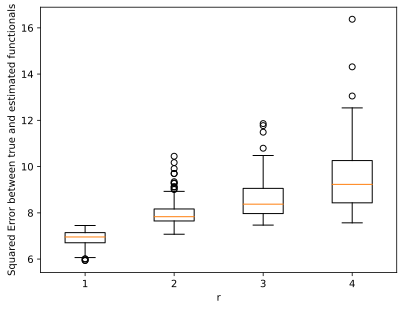

In [10]:
plt.ylabel('Squared Error between true and estimated functionals')
plt.xlabel('r')
plt.boxplot(mse)
# plt.savefig('SE.svg')
# plt.savefig('SE.png')

### Plot the estimated class functionals

We plot the estimated functionals. Each plot represents one feature, and each colour represents one class.

Let $S$ be the spline basis matrix evaluated at all time points for which any data was recorded. Then the class functionals can simply be estimated as $$Y=S(\lambda_0 + \Lambda\alpha_i\xi)$$, where each column represents one feature functional.

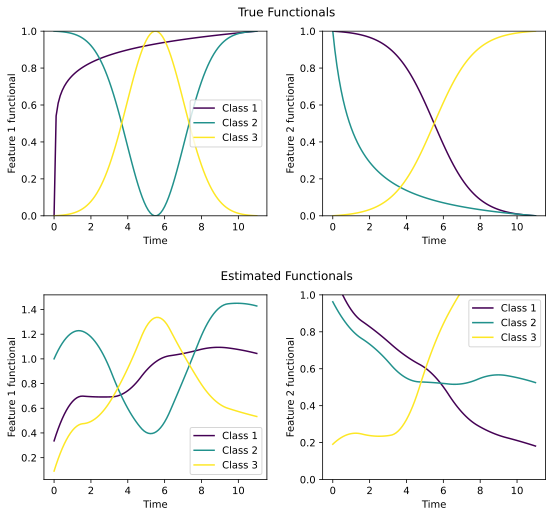

In [17]:
model = MFLDA(n_iter=500, r=2, nBasis=9).fit(X_test, y_test)
xs = np.linspace(0, 1, 100)
fnLibrary = np.array([err + np.log(xs + np.exp(-err)), err * np.exp(-25*(xs - .5)**2), err/(1 + np.exp(-10*(xs - 0.5))), 1/(xs + 1/err), err * (1 - np.exp(-25*(xs - .5)**2)), err/(1 + np.exp(10*(xs - 0.5)))])
ys = fnLibrary[indices].T
xs = np.linspace(model.splineDomain[0], model.splineDomain[1], 100)
S = np.array(model.basis(xs).squeeze().T)
fig = plt.figure('Estimated Functionals')
fig.set_figwidth(9)
fig.set_figheight(7)
subFigs = fig.subfigures(nrows=2, hspace=0.1)
subFigs[0].suptitle('True Functionals')
subFigs[1].suptitle('Estimated Functionals')
ax = [subFigs[1].add_subplot(121), subFigs[1].add_subplot(122)]
for i in range(model.n_classes):
    fn = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
    for j in range(model.n_features):
        className = 'Class ' + str(i+1)
        ax[j].plot(xs, fn[:,j], color=cmap[i], label=className)
# for i in range(3):
#     for j in range(1, X[i*100].shape[1]):
#         featIdx = X[i*100][0, j].astype('int')
#         target = 'Class ' + str(i+1)
#         ax[featIdx].plot(X[i*100][1:,0], X[i*100][1:, j], '.', markersize=15, color=cmap[i])
# ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
ax[1].legend()
ax = [subFigs[0].add_subplot(121), subFigs[0].add_subplot(122)]
ax[0].plot(xs, normalize(ys[:,0]), color=cmap[0], label='Class 1')
ax[1].plot(xs, normalize(ys[:,1]), color=cmap[0], label='Class 1')
ax[0].plot(xs, normalize(ys[:,2]), color=cmap[1], label='Class 2')
ax[1].plot(xs, normalize(ys[:,3]), color=cmap[1], label='Class 2')
ax[0].plot(xs, normalize(ys[:,4]), color=cmap[2], label='Class 3')
ax[1].plot(xs, normalize(ys[:,5]), color=cmap[2], label='Class 3')
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
plt.subplots_adjust(wspace=0.25)
# plt.subfigures_adjust(hspace=0.25)
# ax[1].legend()
# # fig.tight_layout()
# plt.savefig('functionals.svg')

### Dimension Reduction

Let $Y$ be a new datapoint that is not in the training set. Similar to training, we will construct the corresponding $S_Y$ and $C_Y$ matrix. Define $M_Y = \sigma^2I + (C^T\Psi C)\otimes (S\Sigma S^T)$ and $A_Y=(\xi C)^T\otimes(S\Lambda)$. Then, we choose $\hat{\alpha}_Y$ such that $$vec(\hat{\alpha}_Y)=(A_Y^TM_Y^{-1}A_Y)^{-\frac{1}{2}}A_Y^TM_Y^{-1}Y$$ Reshaping into an $r\times r$ matrix and taking the diagonal elements, we arrive at an $r$ dimensional representation of $Y$ that has unit covariance, since $var(vec(Y))=A_Y^TM_Y^{-1}A_Y$.

### Classification

Classification of a sample is done by computing the posterior probabilities of belonging to each class, and then choosing the class with the highest posterior. $$P(\text{class}=i|Y) = \frac{P(Y|\text{class}=i)P(\text{class}=i)}{\sum_{k=1}^KP(Y|\text{class}=k)P(\text{class}=k)}$$ Simplifying this tells us that it is enough to find the class $i$ such that the value of $||\hat{\alpha}_Y - (A_Y^TM_Y^{-1})A)^{\frac{1}{2}}vec(\alpha_i)||_F$ is minimized.

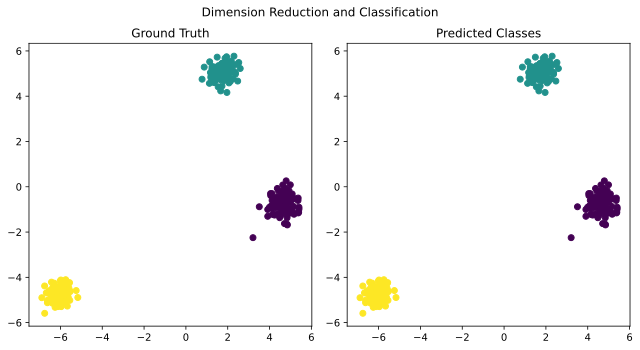

In [19]:
pts = model.transform(X_test)
fig = plt.figure('Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121)
ax.scatter(pts[:,0], pts[:,3], c=y)
ax.set_title('Ground Truth')
ax.set_box_aspect(1)
ax = fig.add_subplot(122)
ax.scatter(pts[:,0], pts[:,3], c=model.predict(X))
ax.set_title('Predicted Classes')
ax.set_box_aspect(1)
fig.suptitle('Dimension Reduction and Classification')
fig.tight_layout()

In [20]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



## r=3

### Fitting the data

In [21]:
model = MFLDA(r=3, n_iter=500).fit(X, y)
pts = model.transform(X)

### Plot the estimated class functionals

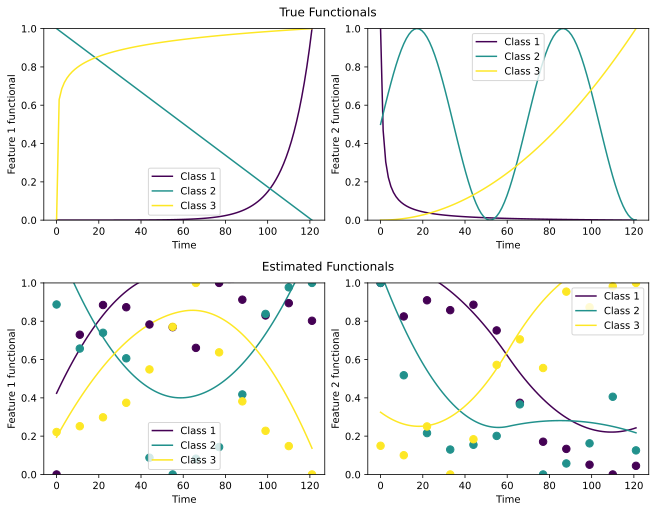

In [22]:
xs = np.linspace(model.splineDomain[0], model.splineDomain[1], 100)
S = np.array(model.basis(xs).squeeze().T)
fig = plt.figure('Estimated Functionals', constrained_layout=True)
fig.set_figwidth(9)
fig.set_figheight(7)
subFigs = fig.subfigures(nrows=2)
subFigs[0].suptitle('True Functionals')
subFigs[1].suptitle('Estimated Functionals')
ax = [subFigs[1].add_subplot(121), subFigs[1].add_subplot(122)]
for i in range(model.n_classes):
    ys = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
    for j in range(model.n_features):
        className = 'Class ' + str(i+1)
        ax[j].plot(xs*11, ys[:,j], color=cmap[i], label=className)
for i in range(3):
    for j in range(1, X[i*100].shape[1]):
        featIdx = X[i*100][0, j].astype('int')
        target = 'Class ' + str(i+1)
        ax[featIdx].plot(X[i*100][1:,0]*11, X[i*100][1:, j], '.', markersize=15, color=cmap[i])
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
ax[1].legend()
ax = [subFigs[0].add_subplot(121), subFigs[0].add_subplot(122)]
ax[0].plot(xs*11, normalize(np.exp(xs)), color=cmap[0], label='Class 1')
ax[1].plot(xs*11, normalize(1/(xs + 0.1)), color=cmap[0], label='Class 1')
ax[0].plot(xs*11, normalize(-xs), color=cmap[1], label='Class 2')
ax[1].plot(xs*11, normalize(np.sin(xs)), color=cmap[1], label='Class 2')
ax[0].plot(xs*11, normalize(np.log(xs + np.exp(-10))), color=cmap[2], label='Class 3')
ax[1].plot(xs*11, normalize(xs**2), color=cmap[2], label='Class 3')
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
ax[1].legend()
# fig.tight_layout()
# plt.savefig('functionals.svg')

### Cluster plots

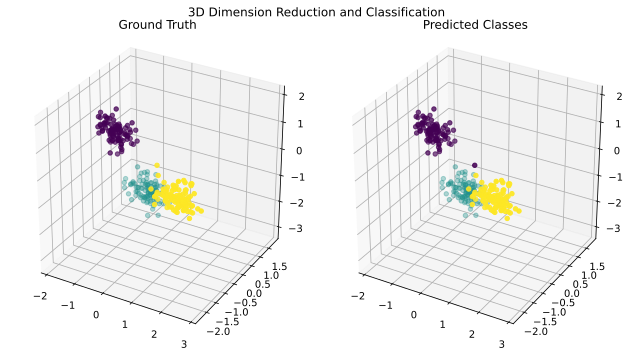

In [23]:
fig = plt.figure('3D Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], c=y)
ax.set_title('Ground Truth')
ax.set_box_aspect((1, 1, 1))
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], c=model.predict(X))
ax.set_title('Predicted Classes')
ax.set_box_aspect((1, 1, 1))
fig.suptitle('3D Dimension Reduction and Classification')
fig.tight_layout()

In [24]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      0.99      0.99       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

